Spawning threads
Magnetizing temperatures


0% [####################] 100% | ETA: 00:00:000% [################### ] 100% | ETA: 00:00:000% [####################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01

Total time elapsed: 00:00:01
Total time elapsed: 00:00:01



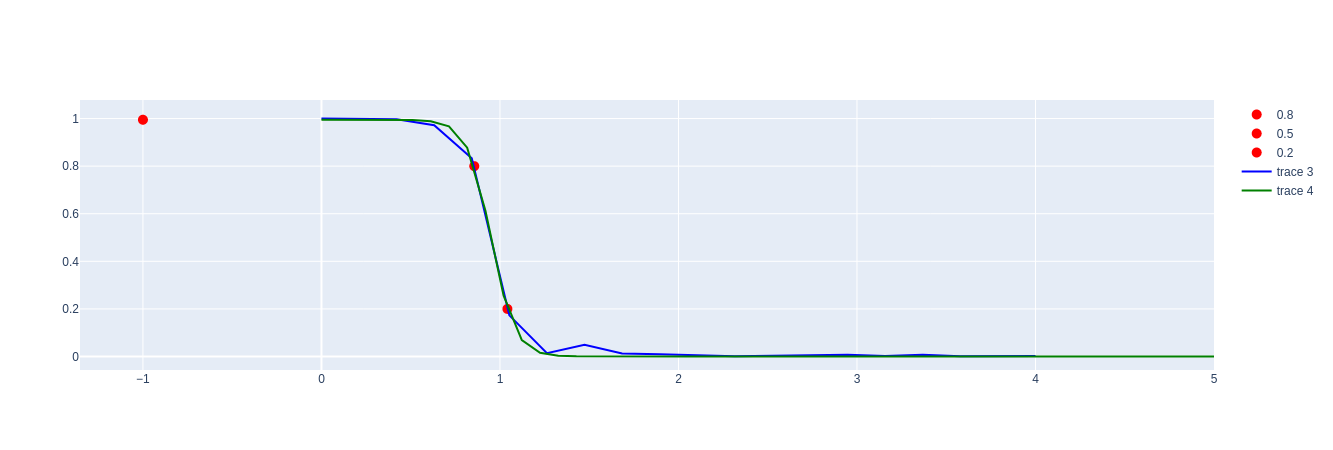

In [4]:
import sys; sys.path.insert(0, '../')
from plexsim.models import *
from plotly import graph_objects as go
import networkx as nx, numpy as np
n = 10
g = nx.grid_graph([n, n], periodic = True)
# g = nx.star_graph(10)
# g = nx.barabasi_albert_graph(n, 3)
# g = nx.complete_graph(3)
m = Potts(graph = g, t = 1.5,\
          updateType = 'async',\
#           sampleSize = 1,\
          p_recomb = .2,\
          agentStates = np.arange(5)
         )
temps = np.linspace(0, 4, 20)
# print(m.mcmc.rand())
# print(m.siteEnergy(m.states))
m.states = 1
out   = m.magnetize(temps)

# sim = m.simulate(int(1e4))

# fig = go.Figure(data = go.Scatter( y = sim.mean(1)))
# fig.show()
# assert 0 

from scipy import optimize
def sig(x, a, b, c):
    return a / (1 + b * np.exp(c * x))

opts, cov = optimize.curve_fit(sig, xdata = temps, ydata = out[0])

thetas = [.8, .5, .2]
ts     = []
data = []

simTemps = []
for theta in thetas:
    res = optimize.minimize(lambda x, c, theta: abs(sig(x, *c) - theta), x0 = 1.5, \
                        args = (opts, theta), method = 'TNC')
    simTemps.append(res.x) 
    line = go.Scatter(x = res.x, y = sig(res.x, *opts), \
                      mode = 'markers',\
                     marker = dict(color = 'red', size = 10),\
                     name = f'{theta}')
    data.append(line) 
    ts.append(res.x)
    
xr = np.linspace(0, 5)
data.append(go.Scatter(x = temps, y = out[0], line = dict(color = 'blue')))
data.append(go.Scatter(x = xr, y = sig(xr, *opts), line = dict(color = 'green')))
fig = go.Figure(data = data)


fig.show()

438
438
445
459
445
404
327
338


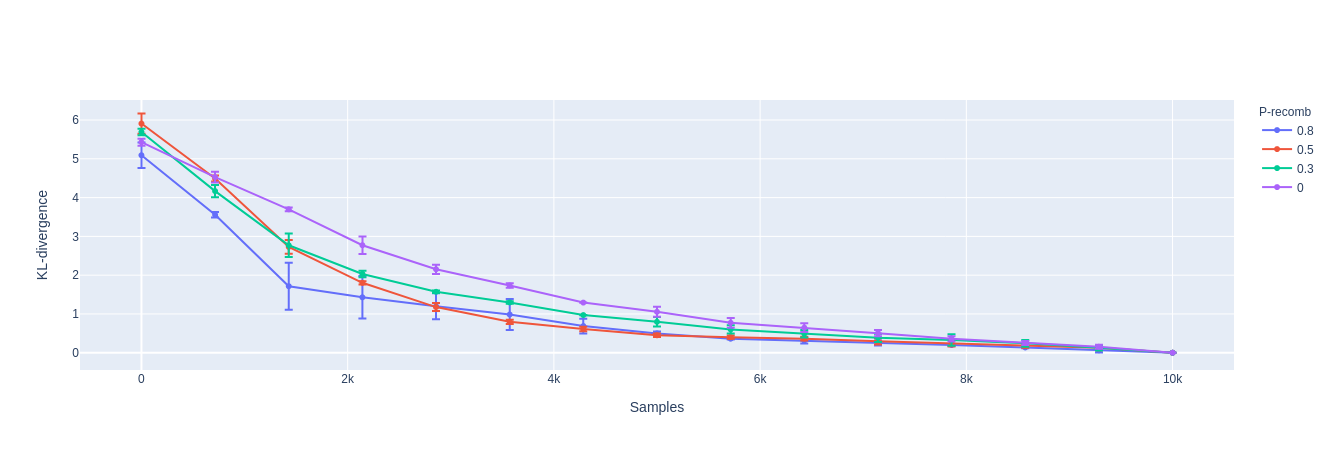

In [21]:
from Toolbox import infcy
from Utils import stats
# m.t = ts[-1]
m.t = .4
ps = [.8, .5, .3, 0]
n  = int(1e4)
ks = np.linspace(0, 1, 15)
nt = 2
output = np.zeros((len(ps), nt, ks.size))

from scipy import special
# p_true = np.ones(m.nNodes)  * .5 #  thetas[0]
for idx, p in enumerate(ps):
    for trial in range(nt):
        m.mcmc.p_recomb = p 
#         m.reset()
        m.states        = 1
        sim             = m.simulate(n)
    
        p_true = {}
        for i in sim:
            p_true[tuple(i)] = p_true.get(tuple(i), 0) + 1/len(sim)
        
        print(len(p_true))
        P_true = np.array([j for i, j in p_true.items()])    
#         print(P_true)
        for jdx, k in enumerate(ks):
            dist = {}
            z = max((1, n*k))
            for i in sim[:int(z)]:
                dist[tuple(i)] = dist.get(tuple(i), 0 )  + 1 /z
             
            P = np.array([dist.get(i, 1e-16)  for i in p_true])
#             KL = (P * (np.log(P) - np.log(P_true))).sum()
#             KL = (P_true * (np.log(P_true) - np.log(P))).sum()
            KL = special.kl_div(P_true, P).sum()
#             print(KL)
#             print(KL.sum)
#             KL = stats.KL(\
#                           *[P_true[None], P[None]]
#                           *[P_true[None], P[None]]
#                          )
            
#             print(KL)
#             print(P_true.sum(), P.sum(), KL)
#             print(KL)
            output[idx, trial,  jdx] = KL
# print(dist, p_true)





lines = []
spacing = 1
from scipy.stats import sem

xr = ks * n 
for (i, name) in zip(output, ps):
    line = go.Scatter( x = xr, y = i.mean(0)[::spacing], \
                      error_y= dict(type = "data",\
                                    array = sem(i[::spacing], 0)),\
                      name = f'{name}')
    lines.append(line)
fig = go.Figure(data = lines)
fig.update_layout(xaxis = dict(title = 'Samples', \
#                               type = 'log',\
                              ),\
                 yaxis = dict(title = 'KL-divergence',\
#                              type = "log",\
                             ),\
                 legend = dict(title = 'P-recomb'))
fig.show()

In [6]:
output

array([[[29.89676485, 27.6149471 , 25.40071489, 23.19682591,
         21.04299099, 18.87933466, 16.75804593, 14.62022951,
         12.52122645, 10.43124106,  8.3203702 ,  6.24550403,
          4.14823189,  2.08583206,  0.        ],
        [29.89676485, 27.6149471 , 25.40071489, 23.19682591,
         21.04299099, 18.87933466, 16.75804593, 14.62022951,
         12.52122645, 10.43124106,  8.3203702 ,  6.24550403,
          4.14823189,  2.08583206,  0.        ]],

       [[29.89676485, 27.6149471 , 25.40071489, 23.19682591,
         21.04299099, 18.87933466, 16.75804593, 14.62022951,
         12.52122645, 10.43124106,  8.3203702 ,  6.24550403,
          4.14823189,  2.08583206,  0.        ],
        [29.89676485, 27.6149471 , 25.40071489, 23.19682591,
         21.04299099, 18.87933466, 16.75804593, 14.62022951,
         12.52122645, 10.43124106,  8.3203702 ,  6.24550403,
          4.14823189,  2.08583206,  0.        ]]])